# Collision Avoidance Controller Demo

This notebook demonstrates the `CollisionAvoidanceController` which implements COLREGs-compliant collision avoidance with virtual waypoint generation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.integrate import solve_ivp

from colav_controllers import CollisionAvoidanceController

/home/mstolberger/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Controller Parameters

- `a`: Heading dynamics coefficient
- `v`: Ship velocity (m/s)
- `eta`: Controller gain (must be > 1)
- `tp`: Prescribed time for heading convergence (seconds)
- `Cs`: Safe distance from obstacle (m)

In [2]:
# Controller parameters
a = 1.0       # Heading dynamics coefficient
v = 2.0       # Ship velocity (m/s)
eta = 2.0     # Controller gain (eta > 1)
tp = 3.0      # Prescribed time (seconds)
Cs = 15.0     # Safe distance from obstacle (m)

controller = CollisionAvoidanceController(a=a, v=v, eta=eta, tp=tp, Cs=Cs)

print(f"Controller initialized with Cs={Cs}m safety radius")

Controller initialized with Cs=15.0m safety radius


## Scenario: Single Obstacle Avoidance

Ship starts heading toward an obstacle and must avoid it (starboard turn per COLREGs).

In [3]:
# Initial state: [x, y, psi]
x0, y0, psi0 = 0.0, 0.0, np.radians(30)  # Heading 30° (northeast)

# Obstacle position
ox, oy = 40.0, 25.0

print(f"Initial position: ({x0}, {y0})")
print(f"Initial heading: {np.degrees(psi0):.1f}°")
print(f"Obstacle at: ({ox}, {oy})")

Initial position: (0.0, 0.0)
Initial heading: 30.0°
Obstacle at: (40.0, 25.0)


In [4]:
# Set virtual waypoint (V1) based on obstacle
controller.set_virtual_waypoint(x0, y0, psi0, ox, oy)

v1 = controller.virtual_waypoint
print(f"Virtual waypoint V1: ({v1[0]:.2f}, {v1[1]:.2f})")

Virtual waypoint V1: (40.00, 10.00)


In [5]:
# Simulation
t_span = (0, 25)
t_eval = np.linspace(0, 25, 500)

def dynamics(t, state):
    """ODE system for collision avoidance."""
    x, y, psi = state
    return controller.compute_dynamics(t, x, y, psi)

sol = solve_ivp(dynamics, t_span, [x0, y0, psi0], t_eval=t_eval, method='RK45')

print(f"Simulation complete: {len(sol.t)} time steps")

Simulation complete: 500 time steps


## Visualization

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


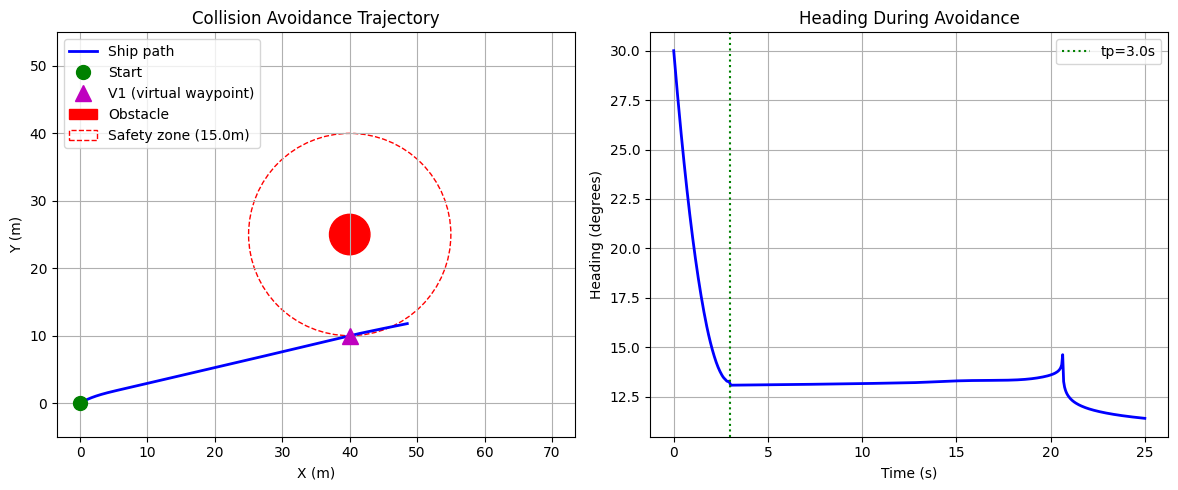

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Trajectory with obstacle
ax = axes[0]
ax.plot(sol.y[0], sol.y[1], 'b-', linewidth=2, label='Ship path')
ax.plot(x0, y0, 'go', markersize=10, label='Start')
ax.plot(v1[0], v1[1], 'm^', markersize=12, label='V1 (virtual waypoint)')

# Draw obstacle and safety zone
obstacle = Circle((ox, oy), 3, color='red', label='Obstacle')
safety_zone = Circle((ox, oy), Cs, color='red', fill=False, linestyle='--', label=f'Safety zone ({Cs}m)')
ax.add_patch(obstacle)
ax.add_patch(safety_zone)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Collision Avoidance Trajectory')
ax.legend(loc='upper left')
ax.grid(True)
ax.axis('equal')
ax.set_xlim(-10, 80)
ax.set_ylim(-10, 60)

# Plot 2: Heading over time
ax = axes[1]
psi_deg = np.degrees(sol.y[2])
ax.plot(sol.t, psi_deg, 'b-', linewidth=2)
ax.axvline(x=tp, color='g', linestyle=':', label=f'tp={tp}s')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Heading (degrees)')
ax.set_title('Heading During Avoidance')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

## Verify Collision Avoidance

Check minimum distance to obstacle during maneuver.

In [7]:
# Calculate distance to obstacle over time
distances = np.sqrt((sol.y[0] - ox)**2 + (sol.y[1] - oy)**2)
min_distance = np.min(distances)
min_idx = np.argmin(distances)

print(f"Minimum distance to obstacle: {min_distance:.2f}m")
print(f"Safety margin Cs: {Cs}m")
print(f"Collision avoided: {min_distance >= Cs}")

Minimum distance to obstacle: 14.66m
Safety margin Cs: 15.0m
Collision avoided: False


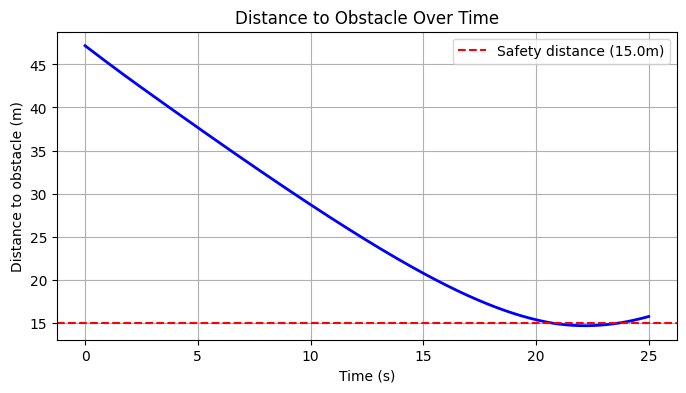

In [8]:
# Plot distance over time
plt.figure(figsize=(8, 4))
plt.plot(sol.t, distances, 'b-', linewidth=2)
plt.axhline(y=Cs, color='r', linestyle='--', label=f'Safety distance ({Cs}m)')
plt.xlabel('Time (s)')
plt.ylabel('Distance to obstacle (m)')
plt.title('Distance to Obstacle Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Multiple Obstacles (Dynamic Mode)

In [9]:
# Reset controller
controller.reset()

# Multiple obstacles: (x, y, velocity, heading)
obstacles = [
    (30.0, 15.0, 0.0, 0.0),
    (50.0, 35.0, 0.0, 0.0),
]

# Set virtual waypoint for multiple obstacles
x0, y0, psi0 = 0.0, 0.0, np.radians(25)
controller.set_virtual_waypoint_dynamic(x0, y0, psi0, obstacles)

v1 = controller.virtual_waypoint
print(f"Virtual waypoint V1: ({v1[0]:.2f}, {v1[1]:.2f})")

Virtual waypoint V1: (30.00, 0.00)


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


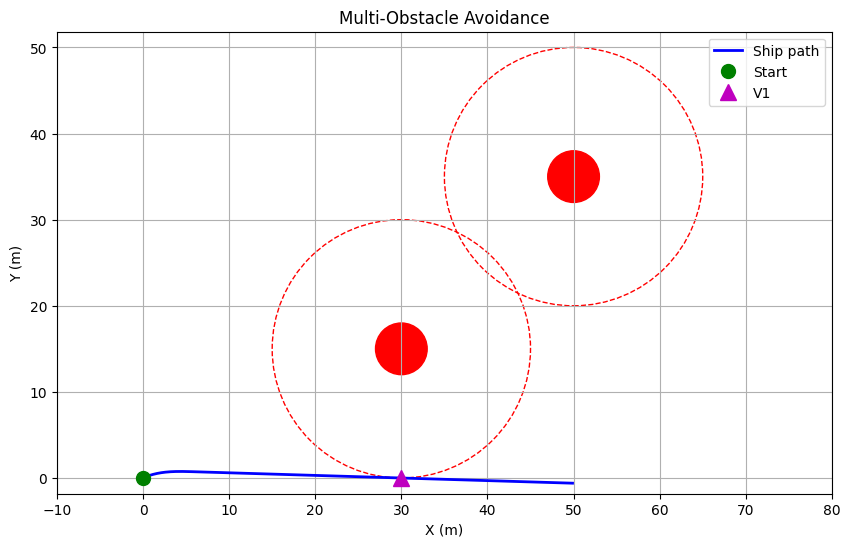

In [10]:
# Simulate
sol2 = solve_ivp(dynamics, t_span, [x0, y0, psi0], t_eval=t_eval, method='RK45')

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sol2.y[0], sol2.y[1], 'b-', linewidth=2, label='Ship path')
ax.plot(x0, y0, 'go', markersize=10, label='Start')
ax.plot(v1[0], v1[1], 'm^', markersize=12, label='V1')

# Draw obstacles
for i, (ox, oy, _, _) in enumerate(obstacles):
    obstacle = Circle((ox, oy), 3, color='red')
    safety_zone = Circle((ox, oy), Cs, color='red', fill=False, linestyle='--')
    ax.add_patch(obstacle)
    ax.add_patch(safety_zone)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Multi-Obstacle Avoidance')
ax.legend()
ax.grid(True)
ax.axis('equal')
ax.set_xlim(-10, 80)
ax.set_ylim(-10, 60)

plt.show()